# PCA diff on hic data
take patient and control data from dlbcl. apply pca on them for some window size. take the difference of these transformed matrices.

## imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import seaborn as sns
from sklearn.decomposition import PCA
import math
from skimage.metrics import structural_similarity as ssim

## import custom functions

In [2]:
import sys
sys.path.append(os.path.abspath(os.path.join('..', '..')))

from lib.chess_functions import clipped_zoom, highlight_features, clip_rotate
from lib.pca import collect_windows, reconstruct_from_windows, apply_pca
from lib.stats import root_mean_squared_error, structural_similarity, explained_variance_score
from lib.load_data import load_hic_data

## load .hic data

In [3]:
patient_region_sub, control_region_sub = load_hic_data()
print("loaded hic")

loaded hic


## perform computations on matrices

In [4]:
# Set window size
window_size = 3
n_components = 0.95

# raw matrices
rot_patient = clip_rotate(patient_region_sub)

rot_control = clip_rotate(control_region_sub)

# Apply PCA
pca_matrix1 = apply_pca(patient_region_sub, window_size, n_components)
rot_pca1 = clip_rotate(pca_matrix1) 

pca_matrix2 = apply_pca(control_region_sub, window_size, n_components)
rot_pca2 = clip_rotate(pca_matrix2)

# Compute PCA difference matrix (patient - control)
diff_pca1 = pca_matrix1 - pca_matrix2 # pca_matrix1 - pca_matrix2
rot_diff_pca1 = clip_rotate(diff_pca1)

# subtract inverse (control - patient)
diff_pca2 = pca_matrix2 - pca_matrix1
rot_diff_pca2 = clip_rotate(diff_pca2)

# log2(obs/exp) calc
safe_div = pca_matrix1 / pca_matrix2
safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_pca1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied
rot_log_pca1 = clip_rotate(log_pca1)

log_pca2 =  np.log2(patient_region_sub / control_region_sub) # pca_matrix1 / pca_matrix2 of normal matrices
rot_log_pca2 = clip_rotate(log_pca2)

## generate plots

Plot saved to out/all_pca_hic.png


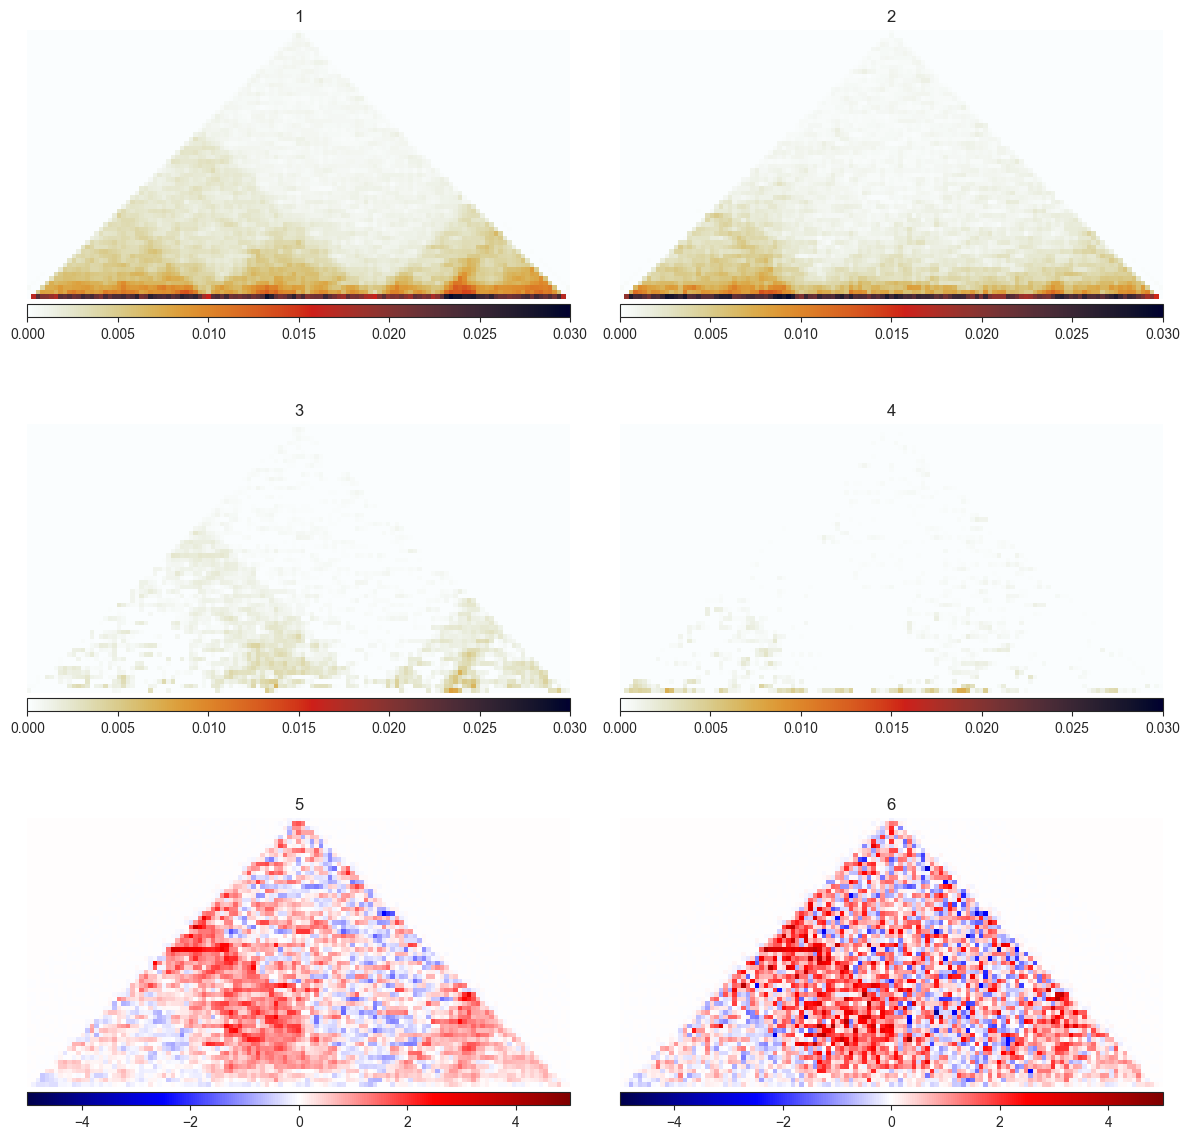

In [5]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

middle = int(np.shape(rot_control)[1]/ 2.)

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(rot_diff_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(rot_log_pca1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(rot_log_pca2[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "all_pca_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")

## concentrated plots
plots for pca applied data, diff, and log transform in one

Plot saved to out/pca_hic.png


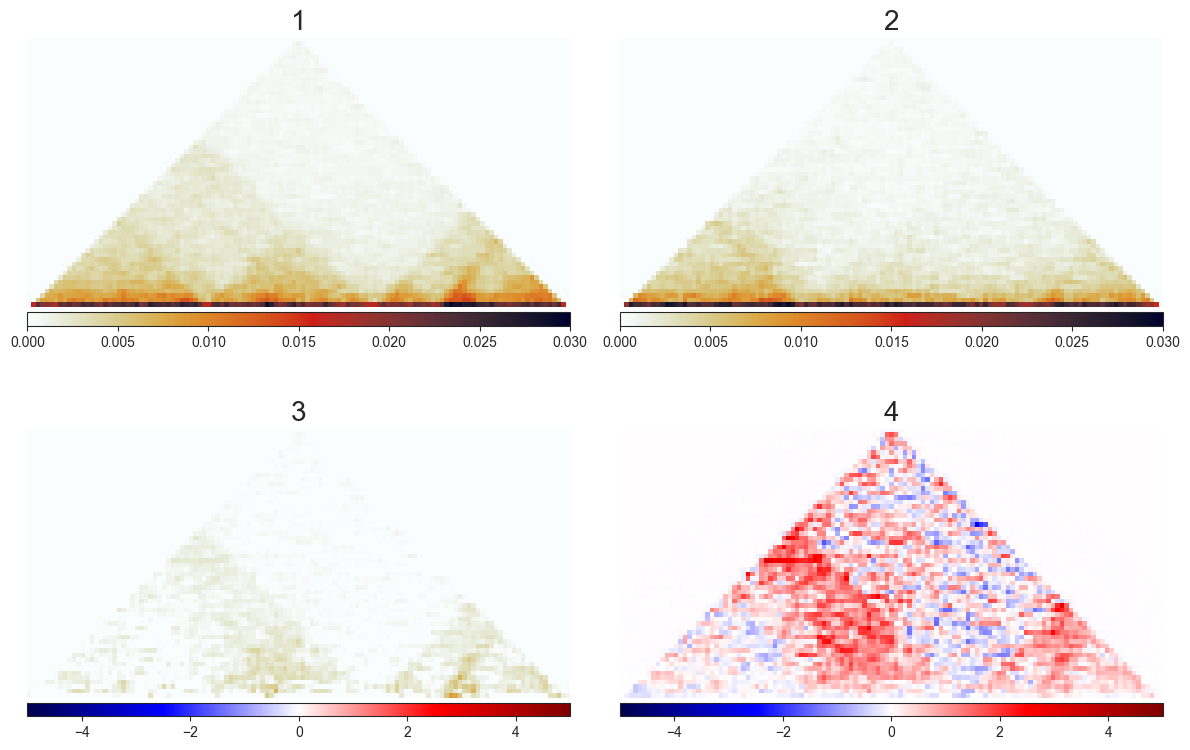

In [6]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

middle = int(np.shape(rot_control)[1]/ 2.)

# First row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1", fontsize=20)

m2 = axes[0][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2", fontsize=20)

# Second row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3", fontsize=20)

m4 = axes[1][1].imshow(rot_log_pca1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[1, 1].set_title("4", fontsize=20)


color_bars = [m1, m2, m3, m4]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "pca_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")

## compute stats
apply ssim, rmse, explained variance stats to determine how well pca denoised the matrix

In [7]:
print("stats for patient")

matrix_1 = patient_region_sub
matrix_2 = pca_matrix1

# More interpretable than MSE since it has the same units as the matrix values.
print("RMSE:", root_mean_squared_error(matrix_1, matrix_2))
# Values closer to 1 indicate better denoising. Useful for image-like matrix data.
print("SSIM:", structural_similarity(matrix_1, matrix_2))
# Closer to 1 means better denoising.
print("Explained Variance:", explained_variance_score(matrix_1, matrix_2))

print("----------")
print("stats for control")

matrix_1 = control_region_sub
matrix_2 = pca_matrix2

print("RMSE:", root_mean_squared_error(matrix_1, matrix_2))
print("SSIM:", structural_similarity(matrix_1, matrix_2))
print("Explained Variance:", explained_variance_score(matrix_1, matrix_2))

stats for patient
RMSE: 0.0008698776305886675
SSIM: 0.9455008878561836
Explained Variance: 0.9791310059549767
----------
stats for control
RMSE: 0.0010030784322756757
SSIM: 0.931176674663269
Explained Variance: 0.9786093352737302
